# Initial Imports

In [2]:
import torch
from torch.autograd import Variable
from torchvision import models
import sys
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import argparse
import time
import tensorly as tl
from tensorly.decomposition import partial_tucker
from decompositions import cp_decomposition_conv_layer, tucker_decomposition_conv_layer

from VBMF import VBMF

from torch.utils.data import Dataset, DataLoader, random_split

from torch.nn.utils.rnn import pad_sequence

import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
from torchvision.io import read_image
from PIL import Image
import glob
import os

import matplotlib.pyplot as plt
plt.ion()   # interactive mode

import pandas as pd
import numpy as np
from glob import glob
import os, os.path
import matplotlib.pyplot as plt
from numpy import asarray

import sklearn.metrics
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC, SVR

from sksurv.datasets import load_gbsg2
# from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, integrated_brier_score

import itertools
from itertools import *

import datetime
import pickle

import torchtuples as tt
from pycox.models import CoxCC
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv

from ptflops import get_model_complexity_info
import torchprofile

from collections import Counter

# Define PyTorch Device

In [3]:
# Use GPU if possible
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# ^ Usually cuda:0, but at time of writing all avaliable memory on GPU 0 is in use.

# Use PyTorch as Tensorly Backend
tl.set_backend('pytorch')

# Force CPU Evaluation (Not Recommended)
# device = torch.device("cpu")

# Helper Functions

In [4]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# Define Dataloaders

### Image Dataset

In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths."""

    def __getitem__(self, index):
        # Get the original tuple from the parent class
        original_tuple = super().__getitem__(index)

        # Get the image file path
        path = self.imgs[index][0]

        # Return a new tuple that includes the original data and the path
        return (*original_tuple, path)

In [5]:
data_dir = "/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x_organized"

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                    #    transforms.Normalize([0.3199, 0.3199, 0.3199], 
                                    #                         [0.2485, 0.2485, 0.2485])
                                                            ])

train_data = datasets.ImageFolderWithPaths(data_dir, transform=train_transforms)

### Image Dataloader

In [6]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False)

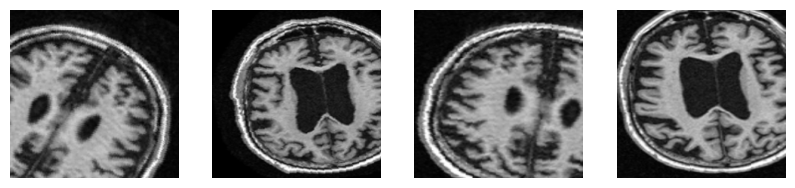

In [7]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    # helper.imshow(images[ii], ax=ax, normalize=False)
    imshow(images[ii], ax=ax, normalize=False)

### Calculate Mean, Standard Deviation for Dataset Images

In [8]:
# Calculate mean and std
mean = 0.0
std = 0.0
nb_samples = 0

for data in trainloader:
    batch_samples = 32  # Batch size (number of images in batch)
    data = data[0]
    data = data.view(batch_samples, data.size(1), -1)  # Reshape to [batch, channels, pixels]
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}, Std: {std}')

Mean: tensor([0.3183, 0.3185, 0.3182]), Std: tensor([0.2514, 0.2513, 0.2512])


In [9]:
# Initialize a Counter for class counts
class_counts = Counter()

for data in trainloader:
    data = data[1]
    class_counts.update(data.tolist())  # Convert labels to list and update the counter

# Print the counts for each class
print("Class Counts:", class_counts)

Class Counts: Counter({2: 981, 1: 748, 0: 453})


# Define Independent Models

Independent evaluation of LOS regression performance and mortality classification performance.

### X-Ray Embedder

In [10]:
class ModifiedVGG16Model(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(ModifiedVGG16Model, self).__init__()

        model = models.vgg16(weights='IMAGENET1K_V1')
        self.features = model.features
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.shared = nn.Sequential( # Try simplififying these layers!
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True))
        
        # Contains the Tail of VGG16 (all 3 FC layers and ReLU, when combined with embedder)
        self.classifier = nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.shared(x)
        x = self.classifier(x)

        return x

# Define Trainer

In [11]:
# Sample weights for cross entropy loss.
adni_weights = torch.load('class_weights.pt').to(device)

In [12]:
class Simple_Trainer:
    def __init__(self, dataloader, model, optimizer, device):
        """
        Initialize the Simple Trainer class.
        Args:
            model: The PyTorch model to be trained and tested.
            device: The device ('cpu' or 'cuda') to train on.
        """
        # FIXME: UPDATE THESE AFTER TRAIN/TEST SPLIT!
        self.train_loader = dataloader
        self.test_loader = dataloader
        self.optimizer = optimizer
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss(weight=adni_weights)

    def train(self, num_epochs):
        """
        Train the model for a given number of epochs.
        Args:
            num_epochs: Number of epochs to train the model.
        """
        self.model.train()

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            for batch in self.train_loader:
                images, labels = batch
                images, labels = images.to(self.device), labels.to(self.device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()

                # Calculate loss
                running_loss += loss.item()
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)  # Get class predictions
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            accuracy = correct / total
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(self.train_loader):.4f}, Accuracy: {accuracy:.4f}")

    def test(self):
        """
        Evaluate the model on the test dataset and compute the average loss.
        """
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in self.test_loader:
                images, labels = batch
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)  # Get class predictions
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_loss = total_loss / len(self.test_loader)
        accuracy = correct / total
        print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Model Evaluation

In [13]:
# Declare model and trainer.
model = ModifiedVGG16Model(num_classes=3)
# optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.99, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
trainer = Simple_Trainer(model=model, dataloader=trainloader, optimizer=optimizer, device=device)

In [14]:
# Performance with no training.
trainer.test()

Test Loss: 1.0907, Test Accuracy: 0.4285


In [15]:
# Force training over entire model.
for param in model.features.parameters():
    param.requires_grad = True

In [16]:
# Train the model.
trainer.train(num_epochs=60)

Epoch [1/60], Loss: 17.3616, Accuracy: 0.5724
Epoch [2/60], Loss: 2.5479, Accuracy: 0.5678
Epoch [3/60], Loss: 1.6295, Accuracy: 0.3506
Epoch [4/60], Loss: 0.9127, Accuracy: 0.4995
Epoch [5/60], Loss: 2.4063, Accuracy: 0.7007
Epoch [6/60], Loss: 1.3505, Accuracy: 0.5307
Epoch [7/60], Loss: 2.2320, Accuracy: 0.3634
Epoch [8/60], Loss: 1.0965, Accuracy: 0.1453
Epoch [9/60], Loss: 1.0094, Accuracy: 0.3556
Epoch [10/60], Loss: 1.1191, Accuracy: 0.4203
Epoch [11/60], Loss: 2.2148, Accuracy: 0.4624
Epoch [12/60], Loss: 1.2329, Accuracy: 0.4170
Epoch [13/60], Loss: 1.2866, Accuracy: 0.6966
Epoch [14/60], Loss: 4.5646, Accuracy: 0.4193
Epoch [15/60], Loss: 1.9205, Accuracy: 0.7026
Epoch [16/60], Loss: 1.9196, Accuracy: 0.4844
Epoch [17/60], Loss: 1.2449, Accuracy: 0.2777
Epoch [18/60], Loss: 1.2737, Accuracy: 0.6357
Epoch [19/60], Loss: 1.3359, Accuracy: 0.4464
Epoch [20/60], Loss: 1.0984, Accuracy: 0.3254
Epoch [21/60], Loss: 1.3085, Accuracy: 0.2782
Epoch [22/60], Loss: 1.7377, Accuracy: 0.3

In [27]:
# Performance after training.
trainer.test()

Test Loss: 16.9095, Test Accuracy: 0.4496


## Test an Alternate Model

In [18]:
num_classes = 3

# Declare model and trainer.
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)  # Replace the last layer for number of classes.

resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001, weight_decay=1e-4)
resnet_trainer = Simple_Trainer(model=resnet_model, dataloader=trainloader, optimizer=resnet_optimizer, device=device)

In [19]:
resnet_trainer.test()

Test Loss: 1.0885, Test Accuracy: 0.3923


In [20]:
# Force training over entire model.
for param in resnet_model.parameters():
    param.requires_grad = True

for param in resnet_model.fc.parameters():
    param.requires_grad = True

In [21]:
resnet_trainer.train(num_epochs=20)

Epoch [1/20], Loss: 1.1133, Accuracy: 0.4858
Epoch [2/20], Loss: 1.1956, Accuracy: 0.3616
Epoch [3/20], Loss: 1.0222, Accuracy: 0.5362
Epoch [4/20], Loss: 1.1517, Accuracy: 0.4734
Epoch [5/20], Loss: 1.0366, Accuracy: 0.5142
Epoch [6/20], Loss: 1.2302, Accuracy: 0.4730
Epoch [7/20], Loss: 1.2074, Accuracy: 0.5115
Epoch [8/20], Loss: 1.1380, Accuracy: 0.4157
Epoch [9/20], Loss: 1.0464, Accuracy: 0.4716
Epoch [10/20], Loss: 1.1515, Accuracy: 0.4148
Epoch [11/20], Loss: 1.0636, Accuracy: 0.4358
Epoch [12/20], Loss: 1.0726, Accuracy: 0.4954
Epoch [13/20], Loss: 1.0311, Accuracy: 0.4950
Epoch [14/20], Loss: 0.9027, Accuracy: 0.5775
Epoch [15/20], Loss: 1.1740, Accuracy: 0.6159
Epoch [16/20], Loss: 0.8999, Accuracy: 0.7186
Epoch [17/20], Loss: 1.0688, Accuracy: 0.6146
Epoch [18/20], Loss: 0.9614, Accuracy: 0.5793
Epoch [19/20], Loss: 1.0110, Accuracy: 0.6095
Epoch [20/20], Loss: 0.9936, Accuracy: 0.4817


In [22]:
resnet_trainer.test()

Test Loss: 1.8663, Test Accuracy: 0.4496
